# DCSI 592: Capstone II

## Predicting Crop Yield in Colorado: Modeling

Dataset: https://catalog.data.gov/dataset/usda-ars-colorado-maize-water-productivity-dataset-2012-2013-f9f68


## 0.0 Imports, Helper Functions & Loading Data

In [68]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [114]:
def display_scores(scores):
    print(f"\tScores: {scores}")
    print(f"\tMean: {scores.mean():.2f}")
    print(f"\tStd Deviation: {scores.std():.2f}")
    return

# apply log transformation and add a constant to deal with 0s
def apply_log_transform_with_constant(dataframe, constant=1e-5):
    # Copy the input dataframe to avoid modifying the original data
    transformed_df = dataframe.copy()
        # Apply logarithmic transformation to numeric columns
    for col in transformed_df.select_dtypes(include=['number']).columns:
        # Add a small constant value to avoid zero values
        transformed_df[col] = np.log(transformed_df[col] + constant)
    return transformed_df

def display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description):
    print(f'{model_description.upper()}')
    print(f'Training MSE: {train_mse:.2f}')
    print(f'Training R2: {train_r2:.2f}')
    print(f'Test MSE: {test_mse:.2f}')
    print(f'Test R2: {test_r2:.2f}')
    print(f'Cross-Validation RMSE:')
    display_scores(cross_val_rmse)
    return


def plot_cv_indices(cv, X, y, ax, n_splits, rmse_scores, lw=10):    
    # Define color maps
    cmap_cv = ListedColormap(["#FF5733", "#33FF57"])  # Orange for training, Green for testing
    cmap_data = plt.get_cmap("viridis")  # gradient for target variable
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

        # plot RMSE for each fold
        ax.text(len(indices), ii + 0.5, f'RMSE: {rmse_scores[ii]:.2f}', verticalalignment='center')

    # plot the target varible dist. (called class)
    scatter = ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data, norm=Normalize(vmin=y.min(), vmax=y.max())
    )

    # format
    yticklabels = list(range(n_splits)) + ["dist of target values"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[0, len(X) + 50],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    # create legend
    legend_elements = [
        plt.Line2D([0], [0], color=cmap_cv(0), lw=4, label='Training'),
        plt.Line2D([0], [0], color=cmap_cv(1), lw=4, label='Testing')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # color bar for target variable dist.
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Target Variable Value')
    return ax

In [101]:
FILE = 'cleaned_annual_data.csv'
maize_data = pd.read_csv(FILE)
maize_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 1   Max_LAI                      94 non-null     float64
 2   Annual_ETc mm                94 non-null     float64
 3   Trt_code                     94 non-null     int64  
 4   Plant density plants ha-1    94 non-null     float64
 5   HI                           94 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 4.5 KB


For our model, we will predict `grain yield` using: 
- irrigation `treatment code` (numerical value that represents the watering deprivation treatment used: the lower value treatments (1, 2, 3...) received more water, while higher values (9, 10, 11...) got less during both periods.Table in appendix)
- `plant density`
- `max leaf area index`

Concept: if a farmer was facing a drought (limited water supply), could they use a model to optimize their watering and still achieve grain yield goals?

In [102]:
features = ["Grain Yield_15.5%mc_Kg ha-1", "Trt_code","Plant density plants ha-1", "Max_LAI"]
maize_model_data = maize_data[features]

In [115]:
log_transformed_model_data = apply_log_transform_with_constant(maize_data)
log_transformed_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Grain Yield_15.5%mc_Kg ha-1  94 non-null     float64
 1   Max_LAI                      94 non-null     float64
 2   Annual_ETc mm                94 non-null     float64
 3   Trt_code                     94 non-null     float64
 4   Plant density plants ha-1    94 non-null     float64
 5   HI                           94 non-null     float64
dtypes: float64(6)
memory usage: 4.5 KB


# Modeling
## 1.0 Linear Regression: Baseline (no transformation)

LINEAR REGRESSION (BASELINE)
Training MSE: 2184176.26
Training R2: 0.39
Test MSE: 3737592.99
Test R2: 0.39
Cross-Validation RMSE:
	Scores: [1069.05034353 1488.4381728  1851.74256705 1643.49770468 1684.88701516]
	Mean: 1547.52
	Std Deviation: 265.73


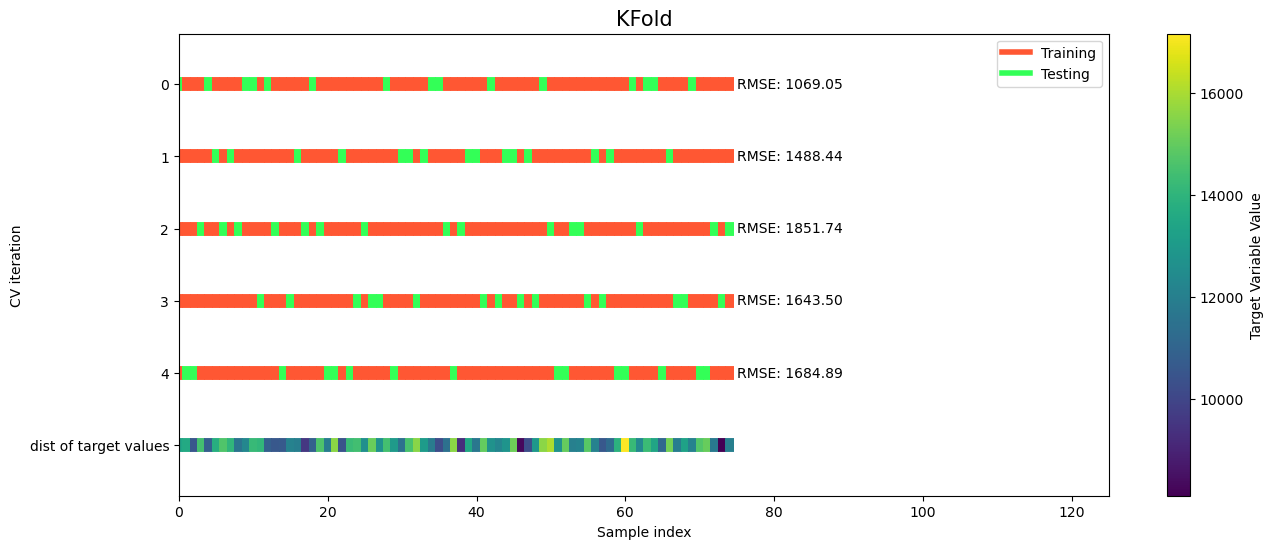

In [129]:
# define features as `X` and target variable (Grain Yield) as `y`   
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model 
linear_regression_model = LinearRegression()

# train the model
linear_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = linear_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = linear_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(linear_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# evaluate model
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="linear regression (baseline)")

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
plot_cv_indices(cv, X_train, y_train, ax, n_splits=5, rmse_scores=cross_val_rmse)
plt.show()

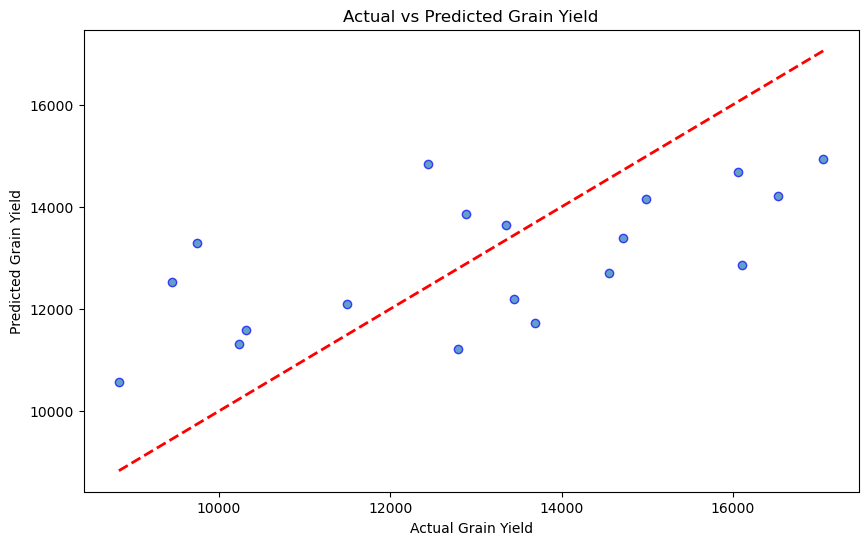

In [127]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors=(0, 0, 1))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grain Yield')
plt.ylabel('Predicted Grain Yield')
plt.title('Actual vs Predicted Grain Yield')
plt.show()

The coefs for this model tell us:
- `Trt_code`: Strong negative relationship with grain yield. For every 1 unit increase in `Treatment_code` (which reduces water usage), the grain yield is expected to decrease by ~338.83 Kg / h1 units. (~746.99 lbs)
- `Plant density plants ha-1`: Very weak positive relationship with grain yield. The impact of plant density is minimal. Every 1 unit increase in this coef, grain yield should increase by 0.03 Kg / h1 units (~.07 lbs) 
- `Max_LAI`: Strong positive relationship with grain yield. This feature has a significant impact on grain yield. For every 1 unit increase in max leaf area, grain yield should increase by 527.54 Kg / h1 units (~1,163.03)

_Note: 1 hectare = 2.47 acres, or 107,639 square feet_

In [135]:
# Get feature names
feature_names = X.columns

# Extract and display the coefficients
coefs = pd.DataFrame(
linear_regression_model.coef_,
    columns=["Coefficients"],
    index=feature_names
)

coefs

,Coefficients
Trt_code,-338.829080
Plant density plants ha-1,0.036397
Max_LAI,527.542289


## 1.1 Linear Regression with log transformation

LINEAR REGRESSION (LOG TRANSFORMED)
Training MSE: 0.01
Training R2: 0.44
Test MSE: 0.02
Test R2: 0.46
Cross-Validation RMSE:
	Scores: [0.14255537 0.11757067 0.12756701 0.13771425 0.11715205]
	Mean: 0.13
	Std Deviation: 0.01


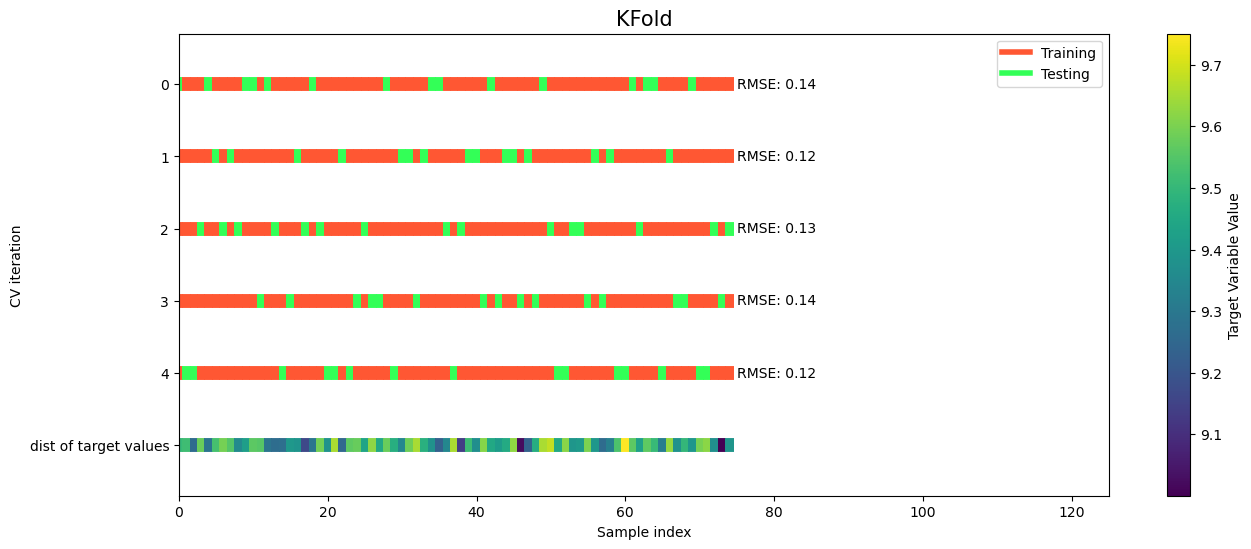

In [125]:
# define features as `X` and target variable (Grain Yield) as `y`   
X = log_transformed_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = log_transformed_model_data['Grain Yield_15.5%mc_Kg ha-1']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the model 
linear_regression_model = LinearRegression()

# train the model
linear_regression_model.fit(X_train, y_train)

# Calculate training MSE and R2
y_train_pred = linear_regression_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate test MSE and R2
y_test_pred = linear_regression_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# perform cross-validation on the training set
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cross_val_mse = cross_val_score(linear_regression_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

# evaluate model
display_model_results(train_mse, train_r2, test_mse, test_r2, cross_val_rmse, model_description="linear regression (log transformed)")

# Plotting
fig, ax = plt.subplots(figsize=(15, 6))
plot_cv_indices(cv, X_train, y_train, ax, n_splits=5, rmse_scores=cross_val_rmse)
plt.show()

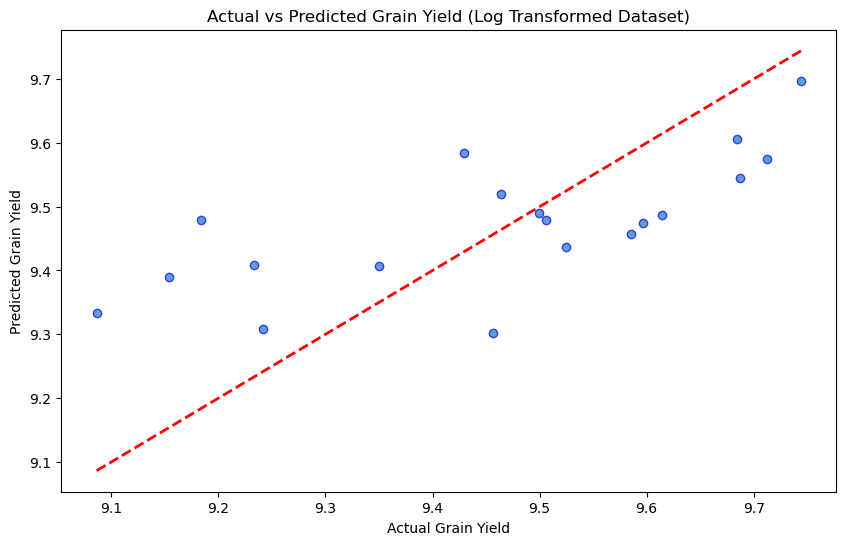

In [124]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors=(0, 0, 1))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Grain Yield')
plt.ylabel('Predicted Grain Yield')
plt.title('Actual vs Predicted Grain Yield (Log Transformed Dataset)')
plt.show()

## 02. Ridge Model & Group K-Fold Cross Validation




In [121]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


# Define features as `X` and target variable (Grain Yield) as `y`
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']
groups = maize_model_data['Trt_code']  # Trt_code is the grouping variable

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, random_state=42)

# Initialize the model
ridge_model = Ridge(alpha=1.0)

# Perform Group K-Fold cross-validation
cv = GroupKFold(n_splits=5)
cross_val_mse = cross_val_score(ridge_model, X_train, y_train, groups=groups_train, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_mse)

print('Cross-Validation RMSE Scores:')
print(cross_val_rmse)
print(f'Mean CV RMSE: {np.mean(cross_val_rmse)}')
print(f'Standard Deviation CV RMSE: {np.std(cross_val_rmse)}')

# Train the model on the entire training set
ridge_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE:', train_mse)
print('Training R2:', train_r2)
print('Test MSE:', test_mse)
print('Test R2:', test_r2)

Cross-Validation RMSE Scores:
[1138.11344658 2211.46419701 1677.17112564 1899.60881838 1585.69922156]
Mean CV RMSE: 1702.4113618337092
Standard Deviation CV RMSE: 355.1654702374665
Training MSE: 2184481.334091581
Training R2: 0.3907873533674311
Test MSE: 3745429.1803783146
Test R2: 0.3857602615473694


In [122]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, make_scorer


# Define features as `X` and target variable (Grain Yield) as `y`
X = maize_model_data.drop(columns=['Grain Yield_15.5%mc_Kg ha-1'])
y = maize_model_data['Grain Yield_15.5%mc_Kg ha-1']
groups = maize_model_data['Trt_code']  # Trt_code is the grouping variable

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {'alpha': np.logspace(-3, 3, 13)}

# Initialize Ridge regression model
ridge_model = Ridge()

# Initialize Group K-Fold cross-validation
cv = GroupKFold(n_splits=5)

# Define the scoring method
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(ridge_model, param_grid, cv=cv, scoring=scorer, refit=True)

# Fit GridSearchCV
grid_search.fit(X, y, groups=groups)

# Get the best model and its alpha value
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']
best_score = np.sqrt(-grid_search.best_score_)

print(f"Best Alpha: {best_alpha}")
print(f"Best RMSE: {best_score}")

# Optionally, evaluate the model on the test set if you have one
# Assuming you already have X_train, X_test, y_train, y_test, groups_train, groups_test
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
y_test_pred = ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE with Best Alpha: {test_rmse}")


Best Alpha: 0.001
Best RMSE: 1725.9492871436132
Test RMSE with Best Alpha: 1933.287676210804


# Appendix



| **Trt Code** | **Irr Treatment (late veg/grain filling)** |
|--------------|-------------------|
| 1            | 100/100           |
| 2            | 100/50            |
| 3            | 80/80             |
| 4            | 80/65             |
| 5            | 80/50             |
| 6            | 80/40             |
| 7            | 65/80             |
| 8            | 65/65             |
| 9            | 65/50             |
| 10           | 65/40             |
| 11           | 50/50             |
| 12           | 40/40             |